In [3]:
import yfinance as yf
import pandas as pd

# Fetch historical data for a specific stock (e.g., AAPL)
ticker = 'AAPL' # Apple Inc.
start_date = '2020-01-01'
end_date = '2024-12-31'

# Download historical daily stock data, selecting a time frame
df = yf.download('AAPL', start='2020-01-01', end='2024-12-31', group_by='column')

# live data for AAPL, getting data for 1 day and sampled every 1 minute
data = yf.download('AAPL', period='1d', interval='1m')  # 1-minute intervals
latest_price = data['Close'].iloc[-1] #select the latest close data

# Display first few rows
print(df.head())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-01-02  72.716080  72.776606  71.466820  71.721026  135480400
2020-01-03  72.009125  72.771752  71.783969  71.941336  146322800
2020-01-06  72.582901  72.621639  70.876068  71.127858  118387200
2020-01-07  72.241531  72.849208  72.021215  72.592578  108872000
2020-01-08  73.403641  73.706271  71.943751  71.943751  132079200


In [4]:
import numpy as np

# Remove duplicate rows (if any)
df.drop_duplicates(inplace=True)

# Handle missing values
# Drop rows with any empty values
df.dropna(inplace=True)

# alternative: Fill missing values with forward-fill
# df.fillna(method='ffill', inplace=True)

# Categorical data handling (for example: adding weekday as a feature)
df['DayOfWeek'] = df.index.dayofweek  # 0 = Monday, 4 = Friday

# Convert to one-hot encoding
df = pd.get_dummies(df, columns=['DayOfWeek'], prefix='Weekday')

# Check final dataset shape and columns
print(df.shape)
print(df.columns)

# Flatten the multi-index column names to strings
df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

# access columns Close and Open
print(df[['Close', 'Open', 'Weekday_0']].head())

print(df[['Close', 'Open']].head())



(1257, 10)
Index([ ('Close', 'AAPL'),   ('High', 'AAPL'),    ('Low', 'AAPL'),
         ('Open', 'AAPL'), ('Volume', 'AAPL'),        'Weekday_0',
              'Weekday_1',        'Weekday_2',        'Weekday_3',
              'Weekday_4'],
      dtype='object')
                Close       Open  Weekday_0
Date                                       
2020-01-02  72.716080  71.721026      False
2020-01-03  72.009125  71.941336      False
2020-01-06  72.582901  71.127858       True
2020-01-07  72.241531  72.592578      False
2020-01-08  73.403641  71.943751      False
                Close       Open
Date                            
2020-01-02  72.716080  71.721026
2020-01-03  72.009125  71.941336
2020-01-06  72.582901  71.127858
2020-01-07  72.241531  72.592578
2020-01-08  73.403641  71.943751


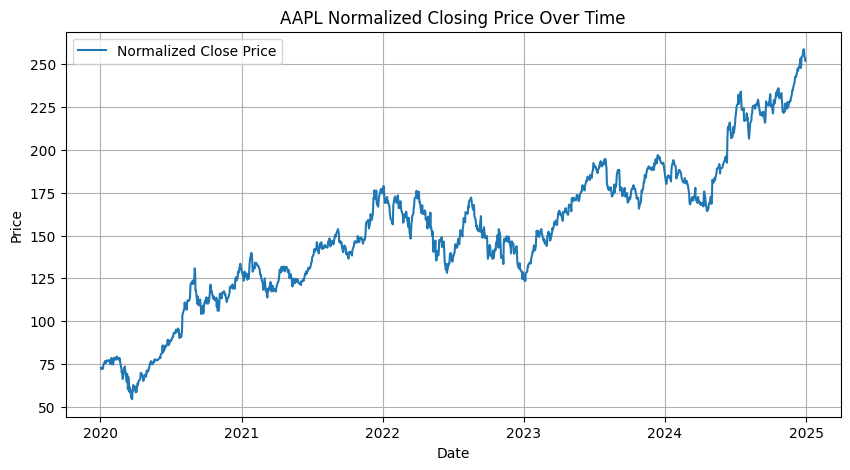

In [5]:
# data visualization of closing price over time for Apple Inc.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df['Close'], label='Normalized Close Price')
plt.title('AAPL Normalized Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
print(df.columns)

# Create technical indicators in data frame
df['MA_10'] = df['Close'].rolling(window=10).mean() # MA_10 meaning 10-day moving average, it is the average of the closing prices over the last 10 days

# function to help compute RSI indicator, RSI indicator: Relative Strength Index
# RSI is a momentum oscillator that measures the speed and change of price movements.
# It compares the average gains and average losses over a certain period (usually 14 days).

# RSI > 70 → Overbought (price may drop soon)
# RSI < 30 → Oversold (price may rise soon)
# RSI ≈ 50 → Neutral momentum

def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()

    rs = avg_gain / (avg_loss + 1e-10)
    rsi = 100 - (100 / (1 + rs))

    return rsi


df['RSI'] = compute_rsi(df['Close'])

# checking empty values in MA_10 and RSI
print(df[['MA_10', 'RSI']].isnull().sum())

# dropping empty values
df.dropna(inplace=True)

# check for empty values for all features
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA_10', 'RSI']
print(df[features].isnull().sum())
print(df[features].describe())


Index(['Close', 'High', 'Low', 'Open', 'Volume', 'Weekday_0', 'Weekday_1',
       'Weekday_2', 'Weekday_3', 'Weekday_4'],
      dtype='object')
MA_10     9
RSI      14
dtype: int64
Open      0
High      0
Low       0
Close     0
Volume    0
MA_10     0
RSI       0
dtype: int64
              Open         High          Low        Close        Volume  \
count  1243.000000  1243.000000  1243.000000  1243.000000  1.243000e+03   
mean    152.815120   154.510902   151.252174   152.969754  9.017360e+07   
std      41.354783    41.540443    41.210749    41.421411  5.335130e+07   
min      55.350235    55.452160    51.595990    54.449894  2.323470e+07   
25%     127.756411   129.161658   125.981391   127.943649  5.517395e+07   
50%     151.003485   152.803351   149.392332   151.326584  7.598190e+07   
75%     176.903106   178.554865   175.472456   177.269051  1.062106e+08   
max     257.906429   259.814335   257.347047   258.735504  4.265100e+08   

             MA_10          RSI  
count  1243.

In [7]:
# Data scaling using MinMax Scaler
from sklearn.preprocessing import MinMaxScaler

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA_10', 'RSI']
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Drop any rows with empty values after scaling
df.dropna(inplace=True)

In [8]:

# helper function for creating the sequences for LSTM
def create_sequences(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i]) # a rolling window size of 60 days as input
        y.append(data[i, 0])  # Predict closing price
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

X, y = create_sequences(df.values, window_size=60) # convert df into sequential data for LSTM training

In [9]:
# Splitting the data into train and test set (80-20)
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((946, 60, 12), (237, 60, 12), (946,), (237,))

In [10]:
X_train.shape[1] # window size

60

In [11]:
X_train.shape[2] # features number

12

In [45]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense
from keras.models import Sequential
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import Dropout

In [54]:
# create a regressor model
regressor = Sequential()

In [55]:
# Input and the first Bidirectional LSTM layer
regressor.add(Input(shape=(X_train.shape[1], X_train.shape[2]))) # 60 time steps, 12 features per step
regressor.add(Bidirectional(LSTM(units=64, return_sequences=True))) # Bidirentional LSTM layer
regressor.add(Dropout(0.3)) # add a 30% droppout to randomly discard neurons to improve the model

In [56]:
# Second Bidirectional LSTM layer
regressor.add(Bidirectional(LSTM(32, return_sequences=True)))
regressor.add(Dropout(0.3))

In [57]:
# Third LSTM layer (not bidirectional)
regressor.add(LSTM(units=16, return_sequences=False))
regressor.add(Dropout(0.2))

In [58]:
# Fully connected Dense layers
regressor.add(Dense(32, activation='tanh')) # tanh activation function
regressor.add(Dense(1, activation='linear')) # a singluar value
# linear activation

In [59]:
# Compile
regressor.compile(optimizer='adam', loss='mean_squared_error')

In [60]:
print("X_train dtype:", X_train.dtype)  # expecting: float32
print("y_train dtype:", y_train.dtype)  # expecting: float32
print("X_train shape:", X_train.shape)

X_train dtype: float32
y_train dtype: float32
X_train shape: (946, 60, 12)


In [61]:
# Train
history = regressor.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 60s 271ms/step - loss: 0.0884 - val_loss: 0.1023
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - loss: 0.0127 - val_loss: 0.0266
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - loss: 0.0073 - val_loss: 0.0211
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - loss: 0.0061 - val_loss: 0.0171
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - loss: 0.0049 - val_loss: 0.0093
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - loss: 0.0038 - val_loss: 0.0088
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - loss: 0.0034 - val_loss: 0.0062
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - loss: 0.0033 - val_loss: 0.0051
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - loss: 0.0028 - val_loss: 0.0082
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 277ms/step - loss: 0.0027 - val_loss: 0.0061
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/ste

In [62]:
# using the trained LSTM model to predict on the dataset X and makes a 1D array of predicated prices(flatten())
lstm_predictions = regressor.predict(X).flatten()


37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step


In [63]:
# Create trend labels from LSTM predicted prices
price_diff = np.diff(lstm_predictions, prepend=lstm_predictions[0]) #calculate price change between predications
trend_labels = (price_diff > 0).astype(int) # turn into 1, 0.  1 if the price increased, 0 if otherwise (1 goes up , 2 goes down)

In [64]:
# Preparing data for SVM
X_svm = np.column_stack((
    lstm_predictions[:-1],                   # Predicted price
    np.diff(lstm_predictions, prepend=0)[:-1],  # Change in predicted price
    df['RSI'].values[60:-1],                # RSI at each time step
    df['MA_10'].values[60:-1],              # Moving average
))
y_svm = trend_labels[1:] # all but the first trend label
#matching X_svm to trend labels.

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [66]:
# Train-test split for SVM
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    X_svm, y_svm, test_size=0.2, random_state=42
)

# Train SVM
svm_model = SVC(kernel='rbf', class_weight='balanced')
svm_model.fit(X_train_svm, y_train_svm)

# Predict & evaluate
y_pred_svm = svm_model.predict(X_test_svm)
accuracy = accuracy_score(y_test_svm, y_pred_svm)

print("SVM Accuracy on trend classification:", accuracy)

SVM Accuracy on trend classification: 0.759493670886076


Confusion Matrix:
[[ 78  19]
 [ 38 102]]


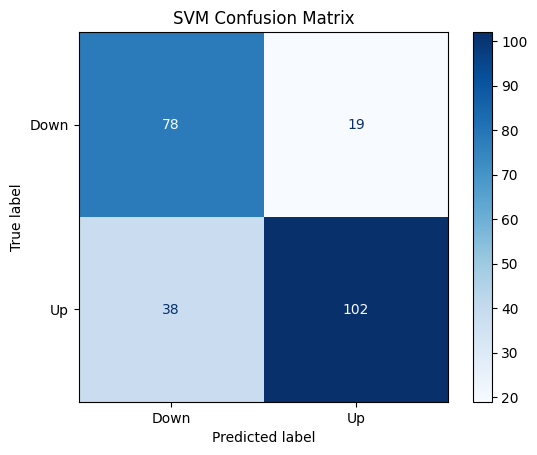


Classification Report:
              precision    recall  f1-score   support

        Down       0.67      0.80      0.73        97
          Up       0.84      0.73      0.78       140

    accuracy                           0.76       237
   macro avg       0.76      0.77      0.76       237
weighted avg       0.77      0.76      0.76       237



In [67]:
# Confusion Matrix and Classification Report for SVM Predictions
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(y_test_svm, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down', 'Up'])

print("Confusion Matrix:")
print(cm)
disp.plot(cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.grid(False)
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_svm, y_pred_svm, target_names=['Down', 'Up']))



In [68]:
# LSTM Evaluation
from sklearn.metrics import mean_squared_error

y_pred_lstm = regressor.predict(X_test).flatten()
mse = mean_squared_error(y_test, y_pred_lstm)
rmse = np.sqrt(mse)

print("LSTM Mean Squared Error:", mse)
print("LSTM Root Mean Squared Error:", rmse)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
LSTM Mean Squared Error: 0.003751764539629221
LSTM Root Mean Squared Error: 0.06125164928089056


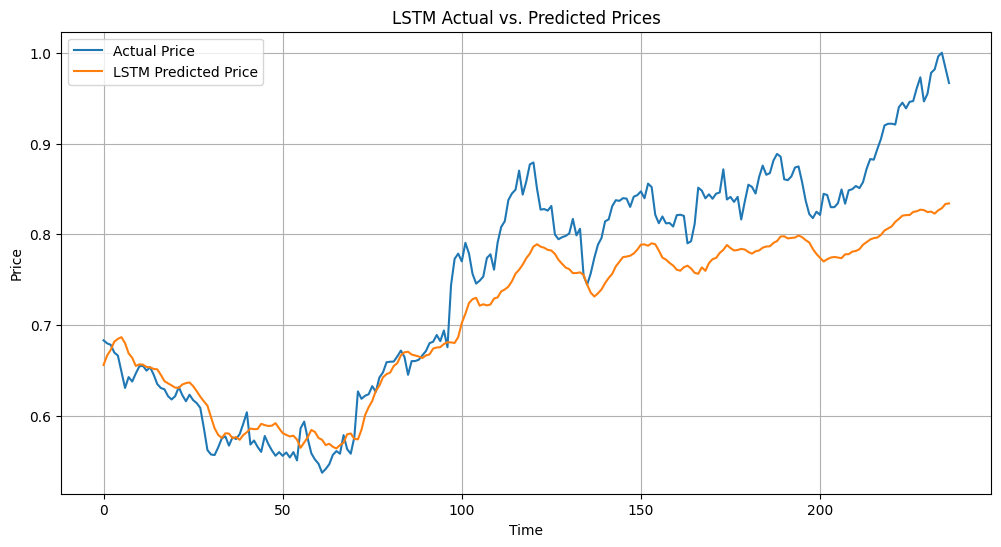

In [69]:
# Visualization

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Price')
plt.plot(y_pred_lstm, label='LSTM Predicted Price')
plt.title('LSTM Actual vs. Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()
